<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/neural-net/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#comment out pips when uploading
#!pip install ruamel.yaml
#!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
from ruamel.yaml import YAML
import json
#import keras_tuner as kt

In [4]:
def load_params():
    "Updates FULL_PARAMS with the values in params.yaml and returns all as a dictionary"
    yaml = YAML(typ="safe")
    with open("params.yaml") as f:
        params = yaml.load(f)
    return params

In [5]:
from matplotlib import text
x = pd.read_csv('dengue_features_train.csv')
y = pd.read_csv('dengue_labels_train.csv')
test =pd.read_csv('dengue_features_test.csv')
before=len(x)

In [6]:
x

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [7]:
y

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [8]:
test=test.drop(columns=['city', 'year', 'week_start_date'])
y=y.drop(columns=['city', 'year'])
x=x.drop(columns=['city', 'year', 'week_start_date'])


weekofyear                               0.216452
ndvi_ne                                 -0.241376
ndvi_nw                                 -0.202235
ndvi_se                                 -0.168612
ndvi_sw                                 -0.196461
precipitation_amt_mm                    -0.038740
reanalysis_air_temp_k                    0.264952
reanalysis_avg_temp_k                    0.151637
reanalysis_dew_point_temp_k              0.142531
reanalysis_max_air_temp_k               -0.191345
reanalysis_min_air_temp_k                0.325252
reanalysis_precip_amt_kg_per_m2         -0.010031
reanalysis_relative_humidity_percent    -0.132452
reanalysis_sat_precip_amt_mm            -0.038740
reanalysis_specific_humidity_g_per_kg    0.129861
reanalysis_tdtr_k                       -0.278483
station_avg_temp_c                       0.116109
station_diur_temp_rng_c                 -0.237844
station_max_temp_c                      -0.039219
station_min_temp_c                       0.267109


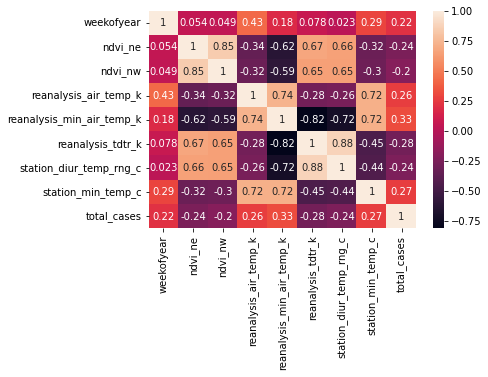

In [9]:
#data analysis
minCorr=.2
x['total_cases']=y['total_cases']
corrMatrix = x.corr()
lastCol=corrMatrix.iloc[:,-1]
print(lastCol)
features=list(lastCol.loc[abs(lastCol) > minCorr].index)
print(features)
x=x[features]
corrMatrix = x.corr()
#sn.heatmap(corrMatrix, annot=True)
#plt.show()

In [10]:
#remove NaN
x['total_cases']=y['total_cases']
x=x.dropna()
test=test.dropna()
y=x['total_cases']
x=x.drop(columns=['total_cases'])
#preprocessing-train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
len(x)/before

0.8310439560439561

In [11]:
#model
#define model
def DNN_model():
  inputShape=(x.shape[1],1)
  model=Sequential()
  #input
  model.add(Dense(200, input_shape=inputShape))
  #hidden layer
  model.add(Dense(100))
  model.add(Dense(50))
  model.add(Dense(25))
  model.add(Dense(10))
  #model.add(Dropout())
  model.add(Flatten())
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [12]:
def tunable_model(hp):
  inputShape=(x.shape[1],1)
  model=Sequential()
  actStart=hp.Choice("activation1", ["relu", "LeakyReLU", "selu", "tanh"])
  actHidden=hp.Choice("activation2", ["relu", "LeakyReLU", "selu", "tanh"])
  actEnd=hp.Choice("activation3", ["relu", "LeakyReLU", "selu", "tanh"])
  #input
  model.add(Dense(hp.Int("units1", min_value=32, max_value=200, step=32), input_shape=inputShape))
  #hidden layer
  model.add(Dense(hp.Int("units2", min_value=32, max_value=100, step=32)))
  model.add(Dense(hp.Int("units3", min_value=2, max_value=50, step=2)))
  model.add(Flatten())
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [13]:
#tuning
#bayes opt
#tuner=kt.BayesianOptimization(tunable_model,objective='val_loss', max_trials=50, overwrite = True)

#tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

#best_model = tuner.get_best_models()[0]
#tuner.results_summary()

Trial 50 Complete [00h 00m 06s]
val_loss: 884.3275756835938

Best val_loss So Far: 880.1400146484375
Total elapsed time: 00h 05m 05s
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
activation1: selu
activation2: relu
activation3: relu
units1: 192
units2: 96
units3: 50
Score: 880.1400146484375
Trial summary
Hyperparameters:
activation1: selu
activation2: relu
activation3: relu
units1: 192
units2: 96
units3: 50
Score: 880.144287109375
Trial summary
Hyperparameters:
activation1: relu
activation2: relu
activation3: relu
units1: 192
units2: 96
units3: 50
Score: 880.3201293945312
Trial summary
Hyperparameters:
activation1: tanh
activation2: tanh
activation3: relu
units1: 192
units2: 32
units3: 50
Score: 880.8119506835938
Trial summary
Hyperparameters:
activation1: tanh
activation2: relu
activation3: tanh
units1: 192
units2: 96
units3: 50
Score: 881.1472778320312
Trial summary
Hyperparameters:
activation1: LeakyReLU
activation2: relu
activat

In [14]:
#training
#ints to float
#test = np.asarray(test).astype('float32')
#x_train = np.asarray(x_train).astype('float32')
#y_train = np.asarray(y_train).astype('float32')
model=DNN_model()
history=model.fit(x,y,epochs=20, validation_split=.1)

Epoch 1/20
35/35 [==============================] - 1s 13ms/step - loss: 1963.9703 - val_loss: 335.6619
Epoch 2/20
35/35 [==============================] - 0s 6ms/step - loss: 1000.8173 - val_loss: 440.9121
Epoch 3/20
35/35 [==============================] - 0s 5ms/step - loss: 1005.8740 - val_loss: 205.7599
Epoch 4/20
35/35 [==============================] - 0s 6ms/step - loss: 960.8873 - val_loss: 200.5064
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 990.0734 - val_loss: 715.8987
Epoch 6/20
35/35 [==============================] - 0s 5ms/step - loss: 991.5854 - val_loss: 345.6231
Epoch 7/20
35/35 [==============================] - 0s 6ms/step - loss: 992.6927 - val_loss: 449.9885
Epoch 8/20
35/35 [==============================] - 0s 6ms/step - loss: 947.5480 - val_loss: 304.9737
Epoch 9/20
35/35 [==============================] - 0s 5ms/step - loss: 919.3251 - val_loss: 291.2529
Epoch 10/20
35/35 [==============================] - 0s 5ms/step - loss: 1031.

In [15]:

#loss

#rmse

#other metrics

In [16]:
#create metrics.json (optional metrics.txt also)
value = {
        "val_loss": history.history['val_loss'][-1],
        "rmse": 0,
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

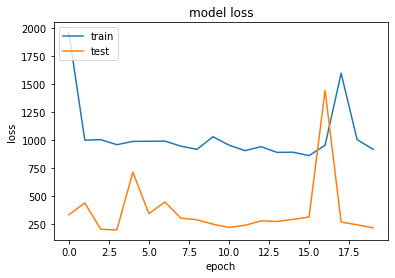

In [17]:
#create a graph called stats.png
plt.tight_layout()
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig1.savefig('stats.png', dpi=100)

In [18]:
#submit predictions fo test
def submit(model, test):
  pred=model.predict(x)